## Database statisctics

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import networkx as nx

import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

%matplotlib inline

In [39]:
def create_bucket(df):
    print("Creating the buckets...")
    buckets = {}
    G=nx.Graph()
    for row in tqdm(df.iterrows()):
        bug_id = row[1]['bug_id']
        dup_id = row[1]['dup_id']
        if dup_id == '[]':
            G.add_node(bug_id)
        else:
            G.add_edges_from([(int(bug_id), int(dup_id))])
    for g in tqdm(nx.connected_components(G)):
        group = set(g)
        for bug in g:
            master = int(bug)
            query = df[df['bug_id'] == master]
            if query.shape[0] <= 0:
                group.remove(master)
                master = np.random.choice(list(group), 1)
            buckets[int(master)] = group
    return buckets

def read_pairs(file_path):
    n = 0
    with open(file_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        for row in f:
            pairs = row.split(' ')
            n += len(pairs) // 2
    return n

def getting_pairs(array):
    res = []
    for row in array:
        _, dups = row
        dups = list(dups)
        while len(dups) > 1:
            bucket = dups[0]
            dups.remove(bucket)
            for d in dups:
                res.append([bucket, d])
    return res

### Datasets

In [3]:
domains = ['eclipse', 'netbeans', 'openoffice', 'firefox']

### Eclipse

In [4]:
DATASET_ECLIPSE = os.path.join('data/normalized/{}'.format(domains[0]), '{}.csv'.format(domains[0]))
df_e = pd.read_csv(DATASET_ECLIPSE)

In [5]:
df_e.head()

,bug_id,bug_severity,bug_status,component,creation_ts,delta_ts,description,dup_id,priority,product,resolution,short_desc,version
0,3,normal,RESOLVED,Team,2001-10-10 21:34:00 -0400,2010-05-07 10:28:53 -0400,KM (10/2/2001 5:55:18 PM)\n\tThis PR about the...,[],P5,Platform,FIXED,Sync does not indicate deletion (1GIEN83),2.0
1,1,normal,CLOSED,Team,2001-10-10 21:34:00 -0400,2012-02-09 15:57:47 -0500,- Setup a project that contains a *.gif resour...,[],P3,Platform,FIXED,Usability issue with external editors (1GE6IRL),2.0
2,8,normal,RESOLVED,Team,2001-10-10 21:34:00 -0400,2011-05-17 11:40:32 -0400,"With the current VCM API, a repository adapter...",[],P3,Platform,WONTFIX,how can we support,2.0
3,4,normal,RESOLVED,Team,2001-10-10 21:34:00 -0400,2002-03-01 16:27:31 -0500,- become synchronized with some project in a r...,[],P5,Platform,FIXED,need better error message if catching up over ...,2.0
4,6,normal,RESOLVED,Team,2001-10-10 21:34:00 -0400,2002-02-07 16:29:37 -0500,IResource.setLocal has problems. This method (...,[],P5,Platform,INVALID,API - IResource.setLocal has problems (1G5TC8L),2.0


In [6]:
df_e[df_e['bug_id'] == 26031]['short_desc']

24605    IllegalArgumentException from ProblemPainter
Name: short_desc, dtype: object

In [7]:
df_e[df_e['bug_id'] == 25881]['short_desc']

24459    IndexOutOfBounds exception during Save
Name: short_desc, dtype: object

In [8]:
df_e[df_e['bug_id'] == 161659]['short_desc'].values[0]

'Frequent workspace crashes'

In [9]:
df_e[df_e['bug_id'] == 164827]['short_desc'].values[0]

'Out of memory error with Mylar?'

#### Bug status

In [10]:
df_e.groupby('bug_status').count()

,bug_id,bug_severity,component,creation_ts,delta_ts,description,dup_id,priority,product,resolution,short_desc,version
bug_status,,,,,,,,,,,,
CLOSED,98510,98510,98510,98510,98510,98510,98510,98510,98510,98510,98510,98510
RESOLVED,218989,218989,218989,218989,218989,218988,218989,218989,218989,218989,218989,218989
VERIFIED,43507,43507,43507,43507,43507,43507,43507,43507,43507,43507,43507,43507


#### Bug Resolution

In [11]:
df_e.groupby('resolution').count()

,bug_id,bug_severity,bug_status,component,creation_ts,delta_ts,description,dup_id,priority,product,short_desc,version
resolution,,,,,,,,,,,,
DUPLICATE,39523,39523,39523,39523,39523,39523,39523,39523,39523,39523,39523,39523
FIXED,234277,234277,234277,234277,234277,234277,234277,234277,234277,234277,234277,234277
INVALID,23070,23070,23070,23070,23070,23070,23069,23070,23070,23070,23070,23070
MOVED,21,21,21,21,21,21,21,21,21,21,21,21
NDUPLICATE,6259,6259,6259,6259,6259,6259,6259,6259,6259,6259,6259,6259
NOT_ECLIPSE,3514,3514,3514,3514,3514,3514,3514,3514,3514,3514,3514,3514
WONTFIX,29102,29102,29102,29102,29102,29102,29102,29102,29102,29102,29102,29102
WORKSFORME,25240,25240,25240,25240,25240,25240,25240,25240,25240,25240,25240,25240


#### Empty textual features

In [12]:
total_issues_no_description = df_e[ df_e['description'] == ' ' ].shape[0]
total_issues_no_title = df_e[ df_e['short_desc'] == ' ' ].shape[0]

print("Total issues no description: {} ({}%)".format(total_issues_no_description, round((total_issues_no_description / df_e.shape[0]) * 100.0), 2))
print("Total issues no title: {} ({}%)".format(total_issues_no_title, round((total_issues_no_title / df_e.shape[0]) * 100.0), 2))

Total issues no description: 3052 (1%)
Total issues no title: 0 (0%)


#### Export eclipse dataset

In [13]:
df_e_filtered = df_e[df_e['resolution'].isin(['DUPLICATE', 'FIXED', 'MOVED', 'NDUPLICATE', 'WONTFIX', 'WORKSFORME'])]
df_e_filtered.groupby('resolution').count()
df_e_filtered.to_csv(DATASET_ECLIPSE, index=False)

### Netbeans

In [14]:
DATASET_NETBEANS = os.path.join('data/normalized/{}'.format(domains[1]), '{}.csv'.format(domains[1]))
df_n = pd.read_csv(DATASET_NETBEANS)

#### Bug status

In [15]:
df_n.groupby('bug_status').count()

,bug_id,bug_severity,component,creation_ts,delta_ts,description,dup_id,priority,product,resolution,short_desc,version
bug_status,,,,,,,,,,,,
CLOSED,37854,37854,37854,37854,37854,37753,37854,37854,37854,37854,37853,37854
RESOLVED,126603,126603,126603,126603,126603,126603,126603,126603,126603,126603,126603,126603
VERIFIED,52258,52258,52258,52258,52258,52258,52258,52258,52258,52258,52258,52258


#### Bug resolution

In [16]:
df_n.groupby('resolution').count()

,bug_id,bug_severity,bug_status,component,creation_ts,delta_ts,description,dup_id,priority,product,short_desc,version
resolution,,,,,,,,,,,,
DUPLICATE,36232,36232,36232,36232,36232,36232,36232,36232,36232,36232,36232,36232
FIXED,120608,120608,120608,120608,120608,120608,120522,120608,120608,120608,120608,120608
INCOMPLETE,4839,4839,4839,4839,4839,4839,4839,4839,4839,4839,4839,4839
INVALID,15198,15198,15198,15198,15198,15198,15194,15198,15198,15198,15197,15198
NDUPLICATE,13,13,13,13,13,13,13,13,13,13,13,13
WONTFIX,19832,19832,19832,19832,19832,19832,19826,19832,19832,19832,19832,19832
WORKSFORME,19993,19993,19993,19993,19993,19993,19988,19993,19993,19993,19993,19993


In [17]:
df_n[df_n['resolution'] == 'INCOMPLETE']

,bug_id,bug_severity,bug_status,component,creation_ts,delta_ts,description,dup_id,priority,product,resolution,short_desc,version
1114,2501,normal,RESOLVED,applet,1999-07-15 20:59:00 +0000,2011-09-19 23:22:34 +0000,[jglick] There were some rumours of Sun coming...,[],P4,obsolete,INCOMPLETE,Suggest providing support in Applet module for...,3.x
7531,10209,blocker,RESOLVED,rmi,2001-03-13 09:34:00 +0000,2011-09-19 23:23:19 +0000,Description: \nit is usefull to have Startup a...,[],P4,obsolete,INCOMPLETE,RMID Wrapper could have Startup action in IDE,3.x
8707,11392,blocker,RESOLVED,vcsgeneric,2001-04-13 13:45:00 +0000,2011-09-19 23:23:27 +0000,NetBeans release 3.2 build #29 (RC2) on Window...,[],P4,obsolete,INCOMPLETE,"ALL: The meaning of ""Unix Shell"" settings sho...",3.x
9101,11794,blocker,RESOLVED,vcscore,2001-04-26 18:35:00 +0000,2011-09-19 23:23:34 +0000,"[NB32-38, RC4]\n\nthere has been an Issue #115...",[],P4,obsolete,INCOMPLETE,Better handling (de)serialization: contextual too,3.x
9841,12540,blocker,RESOLVED,rmi,2001-05-31 21:13:00 +0000,2011-09-19 23:00:02 +0000,This suggestion is based on my experience usin...,[],P3,obsolete,INCOMPLETE,Force generation of stubs for marked Java file,3.x
10027,12731,blocker,RESOLVED,vcsgeneric,2001-06-10 17:04:00 +0000,2011-09-19 23:00:23 +0000,Could the CVS Checkout Select be extended to m...,[],P3,obsolete,INCOMPLETE,"CVS Checkout Select, cater for PARTIAL & WILDC...",3.x
10916,13633,blocker,RESOLVED,netbrowser,2001-07-16 16:50:00 +0000,2011-09-19 22:42:51 +0000,"Currently, we use JTidy to get ""corrected"" pag...",[],P2,obsolete,INCOMPLETE,Loading page is synchronous,3.x
11231,13949,blocker,RESOLVED,vcscore,2001-07-26 10:06:00 +0000,2011-09-19 23:23:44 +0000,in general all command line based vcs tools sh...,[],P4,obsolete,INCOMPLETE,"Support ""Command-Line Style""",3.x
12707,15451,blocker,RESOLVED,Code,2001-09-13 15:30:00 +0000,2011-09-19 23:19:01 +0000,a FS should be converted before a JSP compilation,[],P3,javaee,INCOMPLETE,a FS should be converted before a JSP compilation,3.x
12899,15644,blocker,RESOLVED,corba,2001-09-19 15:27:00 +0000,2011-09-19 23:23:53 +0000,Now implementation generator generates impleme...,[],P4,obsolete,INCOMPLETE,Action for faster access to implementations,3.x


#### Empty textual features

In [18]:
total_issues_no_description = df_n[ df_n['description'] == ' ' ].shape[0]
total_issues_no_title = df_n[ df_n['short_desc'] == ' ' ].shape[0]

print("Total issues no description: {} ({}%)".format(total_issues_no_description, round((total_issues_no_description / df_n.shape[0]) * 100.0), 2))
print("Total issues no title: {} ({}%)".format(total_issues_no_title, round((total_issues_no_title / df_n.shape[0]) * 100.0), 2))

Total issues no description: 2 (0%)
Total issues no title: 0 (0%)


### OpenOffice

In [19]:
DATASET_OPENOFFICE = os.path.join('data/normalized/{}'.format(domains[2]), '{}.csv'.format(domains[2]))
df_o = pd.read_csv(DATASET_OPENOFFICE)

#### Bug status

In [20]:
df_o.groupby('bug_status').count()

,bug_id,bug_severity,component,creation_ts,delta_ts,description,dup_id,priority,product,resolution,short_desc,version
bug_status,,,,,,,,,,,,
CLOSED,89999,89999,89999,89999,89999,89999,89999,89999,89999,89999,89999,89999
RESOLVED,5159,5159,5159,5159,5159,5159,5159,5159,5159,5159,5159,5159
VERIFIED,2912,2912,2912,2912,2912,2912,2912,2912,2912,2912,2912,2912


#### Bug resolution

In [21]:
df_o.groupby('resolution').count()

,bug_id,bug_severity,bug_status,component,creation_ts,delta_ts,description,dup_id,priority,product,short_desc,version
resolution,,,,,,,,,,,,
DUPLICATE,14567,14567,14567,14567,14567,14567,14567,14567,14567,14567,14567,14567
FIXED,48033,48033,48033,48033,48033,48033,48033,48033,48033,48033,48033,48033
IRREPRODUCIBLE,13910,13910,13910,13910,13910,13910,13910,13910,13910,13910,13910,13910
MOVED,5,5,5,5,5,5,5,5,5,5,5,5
NDUPLICATE,5095,5095,5095,5095,5095,5095,5095,5095,5095,5095,5095,5095
NOT_AN_ISSUE,11926,11926,11926,11926,11926,11926,11926,11926,11926,11926,11926,11926
OBSOLETE,191,191,191,191,191,191,191,191,191,191,191,191
WONTFIX,4343,4343,4343,4343,4343,4343,4343,4343,4343,4343,4343,4343


In [22]:
df_o[df_o['resolution'].isin(['OBSOLETE'])]

,bug_id,bug_severity,bug_status,component,creation_ts,delta_ts,description,dup_id,priority,product,resolution,short_desc,version
3831,3988,trivial,CLOSED,ui,2002-04-12 02:38:00 +0000,2013-12-04 15:13:58 +0000,At present the only elements that are common t...,[],P3,Writer,OBSOLETE,relax constraint that objects and frames in he...,641
7741,8250,trivial,RESOLVED,code,2002-10-11 17:22:00 +0000,2013-08-15 16:43:54 +0000,Could anyone help.\n\nI have a macro written i...,[],P3,Writer,OBSOLETE,Importing a Word97 Macro,OOo 1.0.1
9078,9699,major,RESOLVED,ui,2002-11-30 18:00:00 +0000,2013-10-31 06:34:36 +0000,Openoffice 643C is installedin my windows 98 s...,[],P4,Writer,OBSOLETE,CRASH when insert rows into table with maximum...,643C
11502,12375,trivial,RESOLVED,code,2003-03-15 16:17:00 +0000,2013-09-19 09:38:54 +0000,OO 1.02 was working fine until I renamed my ho...,[],P3,Installation,OBSOLETE,Repair doesn't work,OOo 1.0.2
12115,13071,trivial,RESOLVED,ui,2003-04-05 20:29:00 +0000,2013-08-15 16:46:32 +0000,It would be nice to have audio feedback to spe...,[],P3,ui,OBSOLETE,Audio Feedback,OOo 1.1 Beta
14597,15904,trivial,CLOSED,nl,2003-06-22 07:48:00 +0000,2013-07-11 20:55:43 +0000,Als je bij het gebruik van de Nederlandstalige...,[],P3,Native-Lang,OBSOLETE,Fouten in de vertaling van het gebruikersinter...,OOo 1.1
15294,16628,trivial,CLOSED,nl,2003-07-09 22:17:00 +0000,2013-07-12 17:10:30 +0000,De GUI elementen die overeenkomen met de nieuw...,[],P3,Native-Lang,OBSOLETE,Onvolledige vertaling GUI 1.1 in het Nederlands,OOo 1.1 RC
18136,20064,trivial,CLOSED,code,2003-09-25 14:59:00 +0000,2013-07-27 10:42:16 +0000,Product Requirement:\nReduce retraining. Tools...,[],P4,General,OBSOLETE,Q-PCD Remove Main Toolbar,OOo 1.0.0
18174,19958,trivial,CLOSED,Website general issues,2003-09-23 23:52:00 +0000,2013-08-05 15:13:59 +0000,hi\nthe awards page needs to be updated and ne...,[],P3,Infrastructure,OBSOLETE,update awards page,current
19971,22240,minor,RESOLVED,ui,2003-11-07 11:56:00 +0000,2013-12-31 07:58:31 +0000,On PC the OOo-native Open and Save dialogs do ...,[],P3,ui,OBSOLETE,OOo's Open&Save Dialogs should show folder sho...,OOo 1.1


#### Empty textual features

In [23]:
total_issues_no_description = df_o[ df_o['description'] == ' ' ].shape[0]
total_issues_no_title = df_o[ df_o['short_desc'] == ' ' ].shape[0]

print("Total issues no description: {} ({}%)".format(total_issues_no_description, round((total_issues_no_description / df_o.shape[0]) * 100.0), 2))
print("Total issues no title: {} ({}%)".format(total_issues_no_title, round((total_issues_no_title / df_o.shape[0]) * 100.0), 2))

Total issues no description: 0 (0%)
Total issues no title: 0 (0%)


#### Export OpenOffice dataset

In [24]:
df_o_filtered = df_o[df_o['resolution'].isin(['DUPLICATE', 'FIXED', 'MOVED', 'NDUPLICATE', 'WONTFIX', 'OBSOLETE'])]
df_o_filtered.groupby('resolution').count()
df_o_filtered.to_csv(DATASET_OPENOFFICE, index=False)

## Firefox

In [25]:
DATASET_FIREFOX = os.path.join('data/normalized/{}'.format(domains[3]), '{}.csv'.format(domains[3]))
df_f = pd.read_csv(DATASET_FIREFOX)

In [26]:
df_f.tail(50)

,bug_id,priority,component,dup_id,short_desc,description,bug_status,resolution,version,creation_ts,delta_ts
115764,952856,--,Untriaged,463607,Clear recent history is disabled when browser....,User Agent: Mozilla/5.0 (Windows NT 5.1; rv:29...,RESOLVED,DUPLICATE,29 Branch,2013-12-22 12:35:12 -0800,2014-01-08 08:08:54 -0800
115765,952865,--,Developer Tools: Console,[],Intermittent browser_console.js | Timed out wh...,https://tbpl.mozilla.org/php/getParsedLog.php?...,RESOLVED,FIXED,Trunk,2013-12-22 16:38:27 -0800,2014-01-19 18:41:16 -0800
115766,952905,--,Toolbars and Customization,[],Move to Menu and Menu Bar share access key,Right click on the toolbar or tab area.; Menu ...,RESOLVED,FIXED,unspecified,2013-12-22 23:39:15 -0800,2014-01-07 13:19:11 -0800
115767,952926,--,Developer Tools: Inspector,[],Add pointer-events:none to the infobar when an...,Right now; when you inspect an element then sw...,RESOLVED,WORKSFORME,unspecified,2013-12-23 03:20:35 -0800,2014-01-20 08:10:57 -0800
115768,952929,--,Theme,637608,tab scrolling arrows have wrong activation sta...,Created attachment 8351178; Capture d cran de ...,RESOLVED,DUPLICATE,Trunk,2013-12-23 03:55:28 -0800,2013-12-24 03:43:34 -0800
115769,952934,--,Session Restore,[],Use onFrameTreeReset() to re-collect docShell ...,The DocShellCapabilitiesListener in content-se...,RESOLVED,FIXED,Trunk,2013-12-23 04:51:02 -0800,2014-01-07 08:24:36 -0800
115770,952952,--,PDF Viewer,951610,pdf viewer should have a find in document butt...,Find functionality works fine; but is poorly s...,RESOLVED,DUPLICATE,Trunk,2013-12-23 07:57:30 -0800,2014-01-06 15:11:23 -0800
115771,952956,P4,Build Config,[],why does a debug build finish twice as fast as...,User Agent: Mozilla/5.0 (Windows NT 6.1; WOW64...,RESOLVED,INVALID,29 Branch,2013-12-23 08:25:04 -0800,2013-12-30 09:43:57 -0800
115772,952963,--,Toolbars and Customization,[],areaType getter in widget wrapper assumes area...,At http://mxr.mozilla.org/mozilla-central/sour...,RESOLVED,FIXED,Trunk,2013-12-23 10:17:31 -0800,2014-01-03 03:39:11 -0800
115773,952966,--,Untriaged,636374,close tab dialog must not reopen again,User Agent: Mozilla/5.0 (Windows NT 6.1; WOW64...,RESOLVED,DUPLICATE,26 Branch,2013-12-23 10:20:36 -0800,2013-12-26 05:25:25 -0800


In [27]:
df_f.iloc[115795]['description']

'User Agent: Mozilla/5.0 (Windows NT 6.1; WOW64; rv:26.0) Gecko/20100101 Firefox/26.0 (Beta/Release); Build ID: 20131205075310; ; Steps to reproduce:; ; Recently Firefox find bar behavior was modified to include a per-tab behavior remembering search terms for each tab still duplicating the current search terms when opening a new tab. However the search bar (search engine) was not altered and still displays the same value on each tab.; ; This is especially irritating since the search bar is located within the tab just like the URL bar is since quite long time. So users might expect the value there to be tab-specific.; ; Steps to reproduce:; - Just open any tab.; - Enter search term in search bar.; - On new tab enter another search term.; - Switch back to first tab.; ; ; Actual results:; ; - Search terms on first tab will display equal value as entered on any other tab.; ; ; Expected results:; ; When a tab is created it should perhaps inherit the search terms from its parent (just like t

### Bug status

In [28]:
df_f.groupby('bug_status').count()

,bug_id,priority,component,dup_id,short_desc,description,resolution,version,creation_ts,delta_ts
bug_status,,,,,,,,,,
RESOLVED,97929,97929,97929,97929,97927,97197,97929,97929,97929,97929
VERIFIED,17885,17885,17885,17885,17883,17832,17885,17885,17885,17885


### Bug resolution

In [29]:
df_f.groupby('resolution').count()

,bug_id,priority,component,dup_id,short_desc,description,bug_status,version,creation_ts,delta_ts
resolution,,,,,,,,,,
DUPLICATE,35814,35814,35814,35814,35813,35717,35814,35814,35814,35814
EXPIRED,2151,2151,2151,2151,2151,2151,2151,2151,2151,2151
FIXED,19270,19270,19270,19270,19270,18788,19270,19270,19270,19270
INCOMPLETE,17056,17056,17056,17056,17056,17022,17056,17056,17056,17056
INVALID,17388,17388,17388,17388,17385,17283,17388,17388,17388,17388
NDUPLICATE,22,22,22,22,22,22,22,22,22,22
WONTFIX,4715,4715,4715,4715,4715,4678,4715,4715,4715,4715
WORKSFORME,19398,19398,19398,19398,19398,19368,19398,19398,19398,19398


### Empty textual features

In [30]:
total_issues_no_description = df_f[ df_f['description'] == ' ' ].shape[0]
total_issues_no_title = df_f[ df_f['short_desc'] == ' ' ].shape[0]

print("Total issues no description: {} ({}%)".format(total_issues_no_description, round((total_issues_no_description / df_f.shape[0]) * 100.0), 2))
print("Total issues no title: {} ({}%)".format(total_issues_no_title, round((total_issues_no_title / df_f.shape[0]) * 100.0), 2))

Total issues no description: 292 (0%)
Total issues no title: 16 (0%)


### Total of bugs and pairs

In [36]:
df = pd.DataFrame(columns=['domain', 'train_pairs', 'test_pairs', 'total_bugs'])

rows = []

for DOMAIN in domains[:-1]:
    METHOD = 'baseline'
    DIR = 'data/processed/{}'.format(DOMAIN)
    DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
    TRAIN = os.path.join(DIR, 'bert', 'train_chronological.txt')
    TEST = os.path.join(DIR, 'bert', 'test_chronological.txt')
    
    dataset = pd.read_csv(DATASET)
    
    n_train = read_pairs(TRAIN)
    n_test = read_pairs(TEST)
    
    rows.append({ 'domain' : DOMAIN, 'train_pairs' : n_train, 'test_pairs' : n_test, 'total_bugs' :  dataset.shape[0] })
    
df.append(rows)

,domain,train_pairs,test_pairs,total_bugs
0,eclipse,773181,28025,334422
1,netbeans,1280106,35025,216715
2,openoffice,1226059,23065,72234


### Buckets statistics

In [37]:
def get_info_dict(DOMAIN, dataset):
        if dataset is None: return
        # self.info_dict = {'bug_severity': 7, 'bug_status': 3, 'component': 323, 'priority': 5, 'product': 116, 'version': 197}
        df = pd.read_csv(dataset)
        if DOMAIN != 'firefox':
            info_dict = {
                'bug_severity' : df['bug_severity'].unique().shape[0],
                'product' : df['product'].unique().shape[0],
                'bug_status' : df['bug_status'].unique().shape[0],
                'component' : df['component'].unique().shape[0],
                'priority' : df['priority'].unique().shape[0],
                'version' : df['version'].unique().shape[0]
            }
        else:
            info_dict = {
                'bug_status' : df['bug_status'].unique().shape[0],
                'component' : df['component'].unique().shape[0],
                'priority' : df['priority'].unique().shape[0],
                'version' : df['version'].unique().shape[0]
            }
        return info_dict

In [42]:
import _pickle as pickle

bucket_stats = {}

for DOMAIN in domains[:-1]:
    DIR = 'data/processed/{}'.format(DOMAIN)
    DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
    VOCAB = os.path.join(DIR, 'bert', 'word_vocab_bert.pkl')
    
    if DOMAIN not in bucket_stats:
        bucket_stats[DOMAIN] = { 'duplicate' : { }, 'non-duplicate' : 0, 'info' : {}, 'vocab' : { 'distinct' : 0, 'size' : 0 } }
        
    dataset = pd.read_csv(DATASET)
    # Buckets
    buckets = create_bucket(dataset)
    # Vocabulary
    with open(VOCAB, 'rb') as f:
        vocab = pickle.load(f)
        bucket_stats[DOMAIN]['vocab']['distinct'] = len(vocab)
        bucket_stats[DOMAIN]['vocab']['size'] = sum([vocab[key] for key in vocab])
    
    # Info
    bucket_stats[DOMAIN]['info'] = get_info_dict(DOMAIN, DATASET)
    for key in buckets:
        bucket_size = len(buckets[key])
        if bucket_size > 1:
            if bucket_size not in bucket_stats[DOMAIN]['duplicate']:
                bucket_stats[DOMAIN]['duplicate'][bucket_size] = 1
            else:
                bucket_stats[DOMAIN]['duplicate'][bucket_size] += 1
        else:
            bucket_stats[DOMAIN]['non-duplicate'] += 1
bucket_stats

Creating the buckets...


Creating the buckets...


Creating the buckets...


Creating the buckets...


FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/firefox/bert/word_vocab_bert.pkl'

In [45]:
df_master = pd.DataFrame(columns=['domain', 'groups', 'distinct_groups', 'smallest duplicate group', 'biggest duplicate group', 
                                  '50% of duplicates', 'duplicate', 'non-duplicate', 'distinct vocab', 'vocab size', 
                                  'number_severity', 'number_status', 'number_component', 'number_priority', 'number_product',
                                 'number_version'])

rows = []
for index, domain in enumerate(domains[:-1]):
    buckets = pd.DataFrame(data=list(bucket_stats[domain]['duplicate'].keys()), columns=['buckets']).describe()
    rows.append({ 'domain': domain, 
                 'groups' : sum([bucket_stats[domain]['duplicate'][key] for key in bucket_stats[domain]['duplicate']]),
                 'distinct_groups' : len(bucket_stats[domain]['duplicate'].keys()),
                 'smallest duplicate group' : int(buckets['buckets']['min']),
                 '50% of duplicates' : 'duplicate group between 2 and {:.0f} evidences'.format(buckets['buckets']['50%']),
                 'biggest duplicate group' : int(buckets['buckets']['max']),
                'duplicate' : sum([bucket_stats[domain]['duplicate'][key] * key for key in bucket_stats[domain]['duplicate']]),
                'non-duplicate': bucket_stats[domain]['non-duplicate'],
                'distinct vocab' : bucket_stats[domain]['vocab']['distinct'],
                'vocab size' : bucket_stats[domain]['vocab']['size'],
                'number_severity' : bucket_stats[domain]['info']['bug_severity'] if domain != 'firefox' else 0,
                 'number_product' : bucket_stats[domain]['info']['product'] if domain != 'firefox' else 0,
                 'number_status' : bucket_stats[domain]['info']['bug_status'],
                 'number_component' : bucket_stats[domain]['info']['component'],
                 'number_priority' : bucket_stats[domain]['info']['priority'],
                 'number_version' : bucket_stats[domain]['info']['version']
                })
df_master.append(rows)

,domain,groups,distinct_groups,smallest duplicate group,biggest duplicate group,50% of duplicates,duplicate,non-duplicate,distinct vocab,vocab size,number_severity,number_status,number_component,number_priority,number_product,number_version
0,eclipse,62521,35,2,50,duplicate group between 2 and 19 evidences,233415,271901,19998,199989999,7,3,908,5,189,547
1,netbeans,53794,43,2,56,duplicate group between 2 and 23 evidences,248666,162921,19061,181689452,7,3,473,4,39,18
2,openoffice,19794,38,2,99,duplicate group between 2 and 20 evidences,132518,52440,19998,199989999,6,3,137,5,41,537


Vocab size is defined to used at maximum of 200.000 words to be processed. Only eclipse and firefox has reached this value.

eclipse          buckets
count  35.000000
mean   20.457143
std    12.645257
min     2.000000
25%    10.500000
50%    19.000000
75%    28.500000
max    50.000000
netbeans          buckets
count  43.000000
mean   24.674419
std    14.791762
min     2.000000
25%    12.500000
50%    23.000000
75%    36.500000
max    56.000000
openoffice          buckets
count  38.000000
mean   22.947368
std    17.753488
min     2.000000
25%    11.250000
50%    20.500000
75%    29.750000
max    99.000000


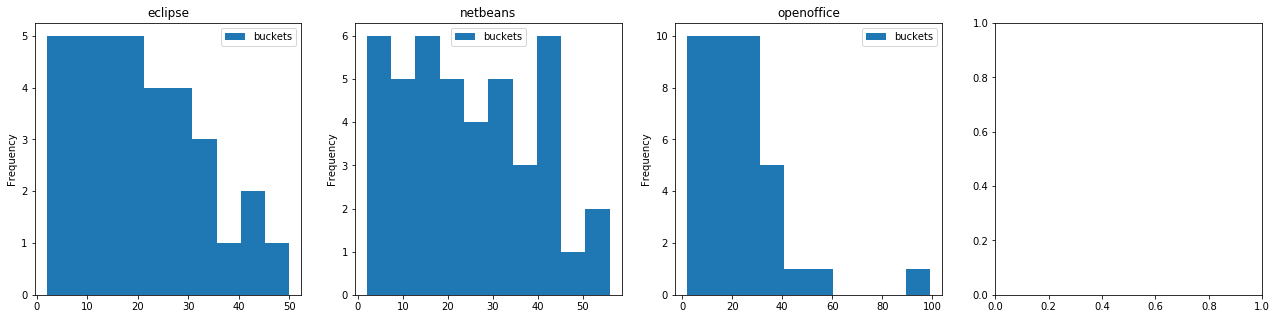

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=len(domains), figsize=(22, 5))

for index, domain in enumerate(domains[:-1]):
    df = pd.DataFrame(data=list(bucket_stats[domain]['duplicate'].keys()), columns=['buckets'])
    df.plot.hist(ax=axes[index])
    
    text = axes[index].set_title('{}'.format(domain))
    
    print(domain, df.describe())